In [71]:
from ipywidgets import widgets, Layout

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from matplotlib import font_manager
from import_casa import casa
font = FontProperties(fname=casa.get_data_path() / "font/NotoSansCJK-Regular.ttc")

In [152]:
ENTITIES = "中華電信 台灣大哥大 遠傳電信 台灣之星 亞太電信 其他".split()
SERVICES = "資費方案 通訊品質 加值服務 其他".split()
def dummy_detect(text):
    ent_probs = [5,.8,.7,.6,.4,.1]
    serv_probs = [4,1,1,0.5]
    return {
        "entity": np.exp(ent_probs)/np.exp(ent_probs).sum(),
        "services": np.exp(serv_probs)/np.exp(serv_probs).sum(),
        "entity_labels": ENTITIES,
        "service_labels": SERVICES,
        "keywords": ["月租費", "吃到飽", "方案", "資費", "網內", "網外"]
    }

In [153]:
data = dummy_detect("中華的吃到飽很快")

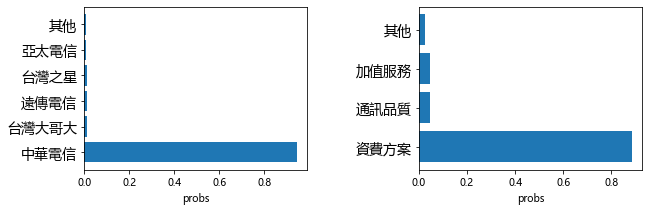

In [154]:
plt.rcParams["font.family"] = "Microsoft YaHei"
fig, axes = plt.subplots(1, 2, figsize=(10,3))
plt.subplots_adjust(wspace=0.5)
axes[0].barh(np.arange(len(ENTITIES)), data["entity"], tick_label=ENTITIES)
axes[0].set_xlabel("probs")
axes[1].barh(np.arange(len(SERVICES)), data["services"], tick_label=SERVICES)
axes[1].set_xlabel("probs")
plt.setp(axes[0].get_yticklabels(), Fontsize=14)
plt.setp(axes[1].get_yticklabels(), Fontsize=14)
input_widgets = widgets.HBox([        
        widgets.Text(description="測試文句", value="中華的吃到飽很快"),        
        widgets.Button(description="偵測")])
widgets.VBox([
    input_widgets, 
    widgets.Label(value="服務關鍵詞：" + " ".join(data["keywords"]))
    ])

In [88]:
import pandas as pd
import pickle
from gensim.models import FastText

In [89]:
path = casa.get_data_path() / "eda/spm/sp_vectors.model"
model = FastText.load(str(path))
model.wv.vectors.shape

[INFO] 2021-01-25 17:35:47,069 gensim.utils: loading FastText object from E:\LangOn\casa\data\eda\spm\sp_vectors.model
[INFO] 2021-01-25 17:35:47,899 gensim.utils: loading wv recursively from E:\LangOn\casa\data\eda\spm\sp_vectors.model.wv.* with mmap=None
[INFO] 2021-01-25 17:35:47,900 gensim.utils: loading vectors_ngrams from E:\LangOn\casa\data\eda\spm\sp_vectors.model.wv.vectors_ngrams.npy with mmap=None
[INFO] 2021-01-25 17:35:55,983 gensim.utils: setting ignored attribute vectors_ngrams_norm to None
[INFO] 2021-01-25 17:35:55,984 gensim.utils: setting ignored attribute vectors_norm to None
[INFO] 2021-01-25 17:35:55,985 gensim.utils: setting ignored attribute vectors_vocab_norm to None
[INFO] 2021-01-25 17:35:55,985 gensim.utils: setting ignored attribute buckets_word to None
[INFO] 2021-01-25 17:35:55,986 gensim.utils: loading vocabulary recursively from E:\LangOn\casa\data\eda\spm\sp_vectors.model.vocabulary.* with mmap=None
[INFO] 2021-01-25 17:35:55,987 gensim.utils: loading 

(5885, 100)

In [106]:
w1 = "不限速吃到飽、4G吃到飽、5G吃到飽、上網吃到飽、499吃到飽、不降速、限速".split("、")
w2 = "繳費、悠遊卡、銀行、信用卡、帳單、加值、現金、費用、聯名卡".split("、")
w3 = "網速、覆蓋率、高速、頻寬、3G、很慢、涵蓋、測速、滿格、品質、連線".split("、")
wv = model.wv
words = w1+w2+w3
wclasses = [1]*len(w1) + [2]*len(w2) + [3]*len(w3)
wvecs = np.vstack([wv.get_vector(w) for w in words])

In [107]:
from sklearn.decomposition import PCA

In [108]:
pca = PCA(2)
wv2d = pca.fit_transform(wvecs)

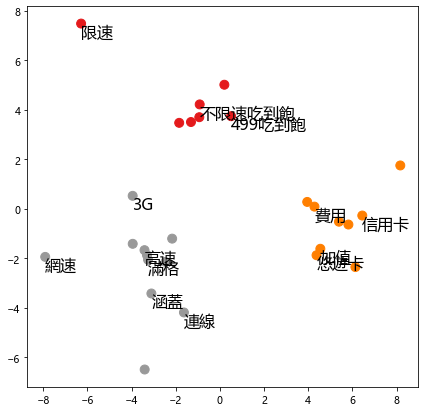

In [151]:
_, axes = plt.subplots(1, 1, figsize=(7,7))
plt.scatter(wv2d[:,0], wv2d[:,1], c=wclasses, s=80, cmap="Set1")
flag = True
for i in range(wvecs.shape[0]):
    if i % 2 != 0: continue
    if words[i].startswith("5G"): continue
    va_val = "top" if flag else "bottom"
    axes.annotate(words[i], (wv2d[i][0], wv2d[i][1]), 
                  fontsize=16, va=va_val)
    flag = !flag

$$
\begin{align}
\phi(\textrm{五大電信}, S) \\
\phi(\textrm{服務類別}, S) \\
\phi(\textrm{seed}, \textrm{token}) = \textrm{cos-sim} (\textrm{seed}, \textrm{piece})
\end{align}
$$